In [7]:
from imread import imread
from lasagne import layers
from lasagne.updates import nesterov_momentum
from matplotlib import pyplot
from nolearn.lasagne import BatchIterator
from nolearn.lasagne import NeuralNet
from pandas import DataFrame
from pandas.io.parsers import read_csv
from scipy import misc
from skimage import data, io, filters
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.utils import shuffle
# import cPickle as pickle
import _pickle as pickle
import numpy as np
import os
import scipy
import sys
import theano
import matplotlib
# matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt

ImportError: No module named 'cPickle'

## Loading images

In [6]:
np.random.seed(0)

In [7]:
IMAGE_SHAPE = (64, 64)
IMAGE_ARRAY_SIZE = IMAGE_SHAPE[0] * IMAGE_SHAPE[1]

def image_files_in_folder(folder):
    all_files = os.listdir(folder)
    return [file for file in all_files if file.endswith('.jpg')]

def read_image(path):
    file = imread(path, as_grey=True)
    file = scipy.misc.imresize(file, IMAGE_SHAPE). \
                      reshape(IMAGE_ARRAY_SIZE)
    return file

def load_images(folder, n_files=None):
    image_files = image_files_in_folder(folder)
    if n_files:
        image_files = np.random.choice(image_files_in_folder(folder), n_files)
    images = np.empty((len(image_files), IMAGE_ARRAY_SIZE),
                      dtype=np.float32)

    for i, file_name in enumerate(image_files):
        try:
            images[i] = read_image('/'.join([folder, file_name]))
        except RuntimeError:
            print(i, file_name)
        print(i, images[i].min(), images[i].max())
    
    return images

In [1]:
# psed_images = load_images('../data/psed-reddit') # 68% with RandomForestClassifier
psed_images = load_images('../data/psed-by-email')
# plt.imshow(psed_images[0].reshape(64, 64), cmap=plt.get_cmap('gray'))

nonpsed_images = load_images('../data/non-psed')
# plt.imshow(nonpsed_images[1].reshape(64, 64), cmap=plt.get_cmap('gray'))

NameError: name 'load_images' is not defined

In [164]:
print('psed_images', psed_images.min(), psed_images.max())
print('nonpsed_images', nonpsed_images.min(), nonpsed_images.max())

NameError: name 'psed_images' is not defined

In [143]:
print(psed_images.shape, nonpsed_images.shape)

X = np.append(psed_images, nonpsed_images, axis=0)

y = np.append(np.repeat(np.array(1, dtype=np.int32), len(psed_images)),
              np.repeat(np.array(0, dtype=np.int32), len(nonpsed_images)))
print(X.shape, y.shape, X.dtype, y.dtype)

print('psed_images', psed_images.min(), psed_images.max())
print('nonpsed_images', nonpsed_images.min(), nonpsed_images.max())
print('X', X.min(), X.max())

(700, 4096) (700, 4096)
(1400, 4096) (1400,) float32 int32
psed_images 0.0 255.0
nonpsed_images 0.0 255.0
X 0.0 255.0


## Models

In [162]:
np.savez('../data/dataset', X=X, y=y)

In [9]:
dataset = np.load('../data/dataset.npz')
X, y = dataset['X'], dataset['y']

In [10]:
# import math

# i = np.append(np.arange(0, 700), [699 + np.random.random_integers(0, 700, math.floor((y == 0).sum() * .66))])
# X = X[i]
# y = y[i]

In [11]:
from sklearn import cross_validation

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, random_state=0, train_size=.8)

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

def plot_roc_curve(clf):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, clf.predict(X_test))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate,
             true_positive_rate,
             'blue',
             label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    print(false_positive_rate, true_positive_rate)

### RandomForestClassifier

In [134]:
parameters = [{'n_estimators' : [3, 5, 10, 20, 30, 100, 500],
               'max_depth': [None, 10, 1e2, 1e3, 1e4, 1e5]}]
random_forest = GridSearchCV(RandomForestClassifier(n_jobs=8, random_state=0),
                             param_grid=parameters)
random_forest.fit(X_train, y_train)
print(random_forest.best_estimator_)

random_forest.score(X_test, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=8,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


0.75357142857142856

In [17]:
paths = [
    '/Users/irio/Desktop/funny_photoshopped_images_01.jpg',
    '/Users/irio/Desktop/plane-nikon-640x0.jpg',
    
    '/Users/irio/Downloads/IMG_2515.JPG',
    '/Users/irio/Downloads/IMG_2525 (1).JPG',
    '/Users/irio/Dropbox/Images/Praça do Japão/PHOT0009.JPG.jpg',
    '/Users/irio/Desktop/WP_20140913_003.jpg',
    '/Users/irio/Desktop/WP_20140913_004.jpg',
    '/Users/irio/Downloads/Photos/IMG_2595.jpg',
    '/Users/irio/Downloads/Photos/IMG_2596.jpg',
    '/Users/irio/Downloads/Photos/IMG_2597.jpg',
    '/Users/irio/Downloads/Photos/IMG_2598.jpg',
    '/Users/irio/Downloads/Photos/IMG_2603.jpg',
]
random_forest.predict(list(map(read_image, paths)))

array([1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0], dtype=int32)

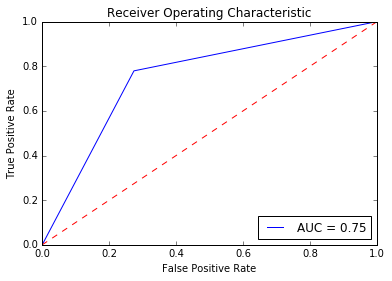

[ 0.          0.27407407  1.        ] [ 0.          0.77931034  1.        ]


In [18]:
plot_roc_curve(random_forest)

### XGBoost

In [11]:
optimized_GBM = GridSearchCV(xgb.XGBClassifier(seed=0), {}, n_jobs=8, verbose=True)
optimized_GBM.fit(X_train, y_train)
print(optimized_GBM.best_estimator_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:   12.6s finished


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


0.711428571429


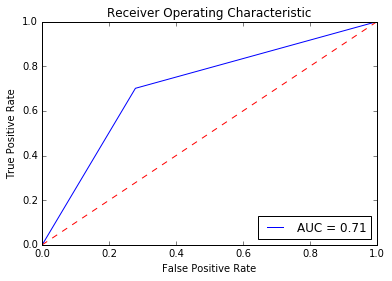

[ 0.          0.27840909  1.        ] [ 0.          0.70114943  1.        ]


array([1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0], dtype=int32)

In [16]:
print(optimized_GBM.score(X_test, y_test))

plot_roc_curve(optimized_GBM)

paths = [
    '/Users/irio/Desktop/funny_photoshopped_images_01.jpg',
    '/Users/irio/Desktop/plane-nikon-640x0.jpg',
    
    '/Users/irio/Downloads/IMG_2515.JPG',
    '/Users/irio/Downloads/IMG_2525 (1).JPG',
    '/Users/irio/Dropbox/Images/Praça do Japão/PHOT0009.JPG.jpg',
    '/Users/irio/Desktop/WP_20140913_003.jpg',
    '/Users/irio/Desktop/WP_20140913_004.jpg',
    '/Users/irio/Downloads/Photos/IMG_2595.jpg',
    '/Users/irio/Downloads/Photos/IMG_2596.jpg',
    '/Users/irio/Downloads/Photos/IMG_2597.jpg',
    '/Users/irio/Downloads/Photos/IMG_2598.jpg',
    '/Users/irio/Downloads/Photos/IMG_2603.jpg',
]

optimized_GBM.predict(list(map(read_image, paths)))

In [22]:
import xgboost as xgb

cv_params = {'max_depth': [3, 5, 7],
             'min_child_weight': [1, 3, 5]}
ind_params = {'learning_rate': 0.1,
              'n_estimators': 1000,
              'seed': 0,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params),
                             cv_params,
                             scoring='accuracy', cv=5, n_jobs=8)
# optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params),
#                              {},
#                              scoring='accuracy', cv=5, n_jobs=8)
optimized_GBM.fit(X_train, y_train)
print(optimized_GBM.best_estimator_)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=5, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)


In [ ]:
print(optimized_GBM.score(X_test, y_test))

plot_roc_curve(optimized_GBM)

paths = [
    '/Users/irio/Desktop/funny_photoshopped_images_01.jpg',
    '/Users/irio/Desktop/plane-nikon-640x0.jpg',
    
    '/Users/irio/Downloads/IMG_2515.JPG',
    '/Users/irio/Downloads/IMG_2525 (1).JPG',
    '/Users/irio/Dropbox/Images/Praça do Japão/PHOT0009.JPG.jpg',
    '/Users/irio/Desktop/WP_20140913_003.jpg',
    '/Users/irio/Desktop/WP_20140913_004.jpg',
    '/Users/irio/Downloads/Photos/IMG_2595.jpg',
    '/Users/irio/Downloads/Photos/IMG_2596.jpg',
    '/Users/irio/Downloads/Photos/IMG_2597.jpg',
    '/Users/irio/Downloads/Photos/IMG_2598.jpg',
    '/Users/irio/Downloads/Photos/IMG_2603.jpg',
]

optimized_GBM.predict(list(map(read_image, paths)))

### OneClassSVM

In [29]:
from sklearn.svm import OneClassSVM

one_class_svm = OneClassSVM()
one_class_svm.fit(X_train, y=y_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.5, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [33]:
len(X_train)

1050

In [49]:
r = one_class_svm.predict(X_test)

In [50]:
minus_y = y_test.copy()
minus_y[minus_y == 1] = -1
(r == minus_y).sum() / float(len(r))

0.49714285714285716

### SVM SVC

In [66]:
from sklearn.svm import SVC

parameters = [{'kernel': ['rbf'],
               'gamma': np.logspace(-3, 3, 7),
               'C': np.logspace(-3, 3, 7),
               'gamma': [0.001]}]
svc = GridSearchCV(SVC(random_state=0),
                   param_grid=parameters)
svc.fit(X_train, y_train)
print(svc.best_estimator_)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)


0.502857142857


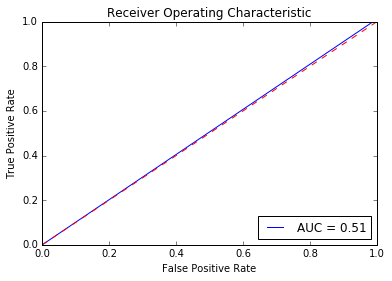

[ 0.          0.98863636  1.        ] [ 0.  1.  1.]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [67]:
print(svc.score(X_test, y_test))

plot_roc_curve(svc)

paths = [
    '/Users/irio/Desktop/funny_photoshopped_images_01.jpg',
    '/Users/irio/Desktop/plane-nikon-640x0.jpg',
    
    '/Users/irio/Downloads/IMG_2515.JPG',
    '/Users/irio/Downloads/IMG_2525 (1).JPG',
    '/Users/irio/Dropbox/Images/Praça do Japão/PHOT0009.JPG.jpg',
    '/Users/irio/Desktop/WP_20140913_003.jpg',
    '/Users/irio/Desktop/WP_20140913_004.jpg',
    '/Users/irio/Downloads/Photos/IMG_2595.jpg',
    '/Users/irio/Downloads/Photos/IMG_2596.jpg',
    '/Users/irio/Downloads/Photos/IMG_2597.jpg',
    '/Users/irio/Downloads/Photos/IMG_2598.jpg',
    '/Users/irio/Downloads/Photos/IMG_2603.jpg',
]

svc.predict(list(map(read_image, paths)))

### Neural Network

In [149]:
net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, IMAGE_ARRAY_SIZE),  # 64x64 input pixels per batch
    hidden_num_units=100,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

#     regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=400,  # we want to train this many epochs
    verbose=1,
)

net1.fit(X, y)

WARNING (theano.sandbox.cuda.opt): Optimization Warning: Got the following error, but you can ignore it. This could cause less GpuElemwise fused together.
(4, -1)
ERROR (theano.gof.opt): Optimization failure due to: constant_folding
ERROR (theano.gof.opt): node: GpuFromHost(TensorConstant{(1,) of 0.9})
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/Users/irio/anaconda2/lib/python3.4/site-packages/theano/gof/opt.py", line 1772, in process_node
    replacements = lopt.transform(node)
  File "/Users/irio/anaconda2/lib/python3.4/site-packages/theano/tensor/opt.py", line 5827, in constant_folding
    required = thunk()
  File "/Users/irio/anaconda2/lib/python3.4/site-packages/theano/gof/op.py", line 883, in rval
    fill_storage()
  File "/Users/irio/anaconda2/lib/python3.4/site-packages/theano/gof/cc.py", line 1707, in __call__
    reraise(exc_type, exc_value, exc_trace)
  File "/Users/irio/anaconda2/lib/python3.4/site-packages/six-1.

RuntimeError: error (unspecified launch failure)copying data to host

In [ ]:
from lasagne.nonlinearities import softmax
from lasagne.updates import adam
from nolearn.lasagne import TrainSplit

layers0 = [
    # layer dealing with the input data
    (layers.InputLayer, {'shape': (1, IMAGE_ARRAY_SIZE)}),

    # first stage of our convolutional layers
    (layers.Conv2DLayer, {'num_filters': 96, 'filter_size': 5}),
    (layers.Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (layers.Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (layers.Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (layers.Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (layers.MaxPool2DLayer, {'pool_size': 2}),

    # second stage of our convolutional layers
    (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
    (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
    (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
    (layers.MaxPool2DLayer, {'pool_size': 2}),

    # two dense layers with dropout
    (layers.DenseLayer, {'num_units': 64}),
    (layers.DropoutLayer, {}),
    (layers.DenseLayer, {'num_units': 64}),

    # the output layer
    (layers.DenseLayer, {'num_units': 10, 'nonlinearity': softmax}),
]

net0 = NeuralNet(
    layers=layers0,
    max_epochs=10,

    update=adam,
    update_learning_rate=0.0002,

    objective_l2=0.0025,

    train_split=TrainSplit(eval_size=0.25),
    verbose=1,
)

net0.fit(X, y)

In [144]:
# print(optimized_GBM.score(X_test, y_test))

# plot_roc_curve(optimized_GBM)

# paths = [
#     '/Users/irio/Desktop/funny_photoshopped_images_01.jpg',
#     '/Users/irio/Desktop/plane-nikon-640x0.jpg',
    
#     '/Users/irio/Downloads/IMG_2515.JPG',
#     '/Users/irio/Downloads/IMG_2525 (1).JPG',
#     '/Users/irio/Dropbox/Images/Praça do Japão/PHOT0009.JPG.jpg',
#     '/Users/irio/Desktop/WP_20140913_003.jpg',
#     '/Users/irio/Desktop/WP_20140913_004.jpg',
#     '/Users/irio/Downloads/Photos/IMG_2595.jpg',
#     '/Users/irio/Downloads/Photos/IMG_2596.jpg',
#     '/Users/irio/Downloads/Photos/IMG_2597.jpg',
#     '/Users/irio/Downloads/Photos/IMG_2598.jpg',
#     '/Users/irio/Downloads/Photos/IMG_2603.jpg',
# ]

# optimized_GBM.predict(list(map(read_image, paths)))

file = imread('/Users/irio/Desktop/funny_photoshopped_images_01.jpg', as_grey=True)
print(file.shape)

all_files = os.listdir('../data/non-psed')
image_shapes = [imread('../data/non-psed/%s' % file, as_grey=True).shape
                for file in all_files if file.endswith('.jpg')]


# file = imread('non-psed/r0a2e85f0t.jpg', as_grey=True)
# print(file.shape)
# file = imread('non-psed/r0a2ff882t.jpg', as_grey=True)
# print(file.shape)

(450, 600)


KeyboardInterrupt: 